## Horizontal Projection Method


(-0.5, 222.5, 393.5, -0.5)

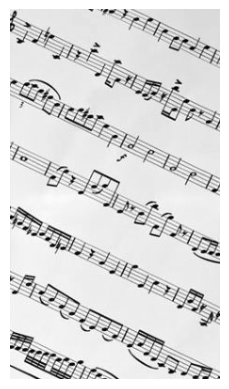

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

# Read the PNG image and convert it to grayscale
image = io.imread("partitura.png", as_gray=True)

# Show the grayscale image
plt.imshow(image, cmap='gray')
plt.axis('off')


Note that in the cell above, the image is represented in gray scale, so that the pixels are valued with numbers between 0 and 1 (with 1 representing white). To apply the horizontal projection, first we need to binarize the image, transforming all pixels either in 1s or 0s.

(-0.5, 222.5, 393.5, -0.5)

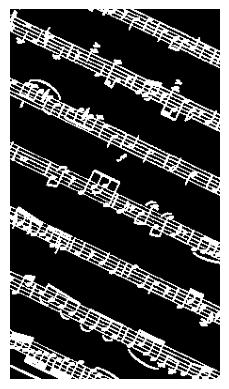

In [ ]:
import numpy as np

bin_image = np.zeros_like(image)
# treshold to convert the content pixels
threshold = 0.8

# Binarizing the image to apply the horizontal projection
bin_image[:,:] = np.where(image[:,:] >= threshold, 0, 1)

plt.imshow(bin_image, cmap='gray')
plt.axis('off')

Note that despite the pixels that represent the letters are showed above as white pixels, the real meaning is that the objective pixels received the 1 value in the image, this way we can apply the horizontal projection by doing the line-wise sum of the pixels that represent text.

In [ ]:
import numpy as np

def sum_lines(array):

  # Initialize an empty array to store the sums.
  line_sums = np.zeros(array.shape[0])

  # Loop through each line of the array and calculate the sum.
  for i in range(array.shape[0]):
    line_sums[i] = np.sum(array[i, :])

  return line_sums

line_sums = sum_lines(bin_image)
print(line_sums.shape)

(394,)


The code snippet above defines a function that executes the line-wise sum of the binarized values of the pixels, returning a vector indexed by the lines of the target image, allowing us to plot the horizontal projection histogram of an image

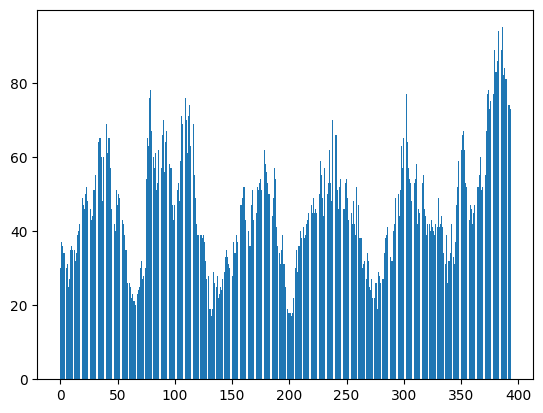

In [ ]:
import matplotlib.pyplot as plt

def plot_horizontal_projection(array):
  # Plot the histogram
  plt.bar(range(len(array)), array)
  # Show the plot
  plt.show()

plot_horizontal_projection(line_sums)

After ploting the horizontal projection histogram, notice that the histogram is mostly completely filled with bars in a given interval. This means that the image is rotated, resulting in a profile projection with degraded amplitude and larger than it should be.

 The method used for finding the inclination angle that the image has been rotate by is defined below. The ```get_hp_inclination``` function ("hp" stands for horizontal projection) takes an image as parameter and rotates it degree-by-degree calculating in each rotation, the value of an ```objetive_function```, defined as the **subtraction of the squared adjacent cells**. Essentially we are looking for the inclination degree, or in other words, the rotation of the image that optimizes the objective function, in this case, the minimun value (since we are subtracting values) of the objective function.



In [ ]:
import numpy as np
from scipy.ndimage import rotate

def objective_function(hor_proj):
  sum = 0
  for i in range(hor_proj.size-1):
    sum += (hor_proj[i]**2 - hor_proj[i+1]**2)
  return sum

def get_hp_inclination(image):
  angle_range = 30
  iteration_rate = 1
  value = np.zeros(angle_range)
  # value 30 is chosen to fasten the process, the angle_range could be any between 0 and 360 degrees
  hor_proj = np.zeros_like(image[:])
  # hor_proj with the line_sums, by definition is the horizontal projection
  for i in range (1, angle_range):
    # Rotate the image by 1 degrees counter-clockwise
    image = rotate(image, 1)
    hor_proj = sum_lines(image)
    value[i] = objective_function(hor_proj)
  image = rotate(image, -angle_range)
  # gets the index of the value hor_proj that maximizes the function
  return np.argmin(value)

inclination = get_hp_inclination(bin_image)
print(inclination)

26


The rotation degree is printed as the return of the function. Notice that the range of angles and the rotation precision (iteration degree rate that is used in the loop) can be altered to cover 360 degrees rotation and to cover more precise rotations in the function, but for demonstration and time saving purposes it was defined in a way that the perfect inclination angle (given the testing image) is found in a fastest execution. Further tests and generalization for another test images can be done altering ```angle_range``` and ```iteration_rate``` parameters.

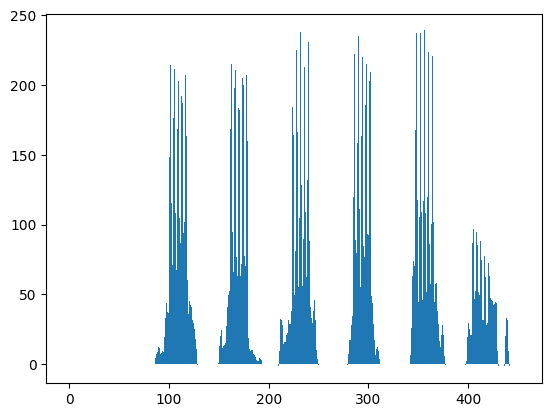

In [ ]:
import numpy as np
from scipy.ndimage import rotate

bin_image = rotate(bin_image, inclination)
plot_horizontal_projection(sum_lines(bin_image))


After rotating the binary image by the returned angle and ploting the horizontal projection, we can see a completely different histogram. Interesting to note that the in the new plot the line separation is visible, as we can see in the *partitura.png* that has a sheet music. In this case, we can see 7 amplitude peaks that represents the 7 parts of the sheet music, as well the 5 inner lines that represent the musical scale in it, as inner peaks into the seven divisions. Is important to notice that our amplitude increasing was correct and the resultant histogram has more than twice the amplitude of the original.

(-0.5, 372.5, 451.5, -0.5)

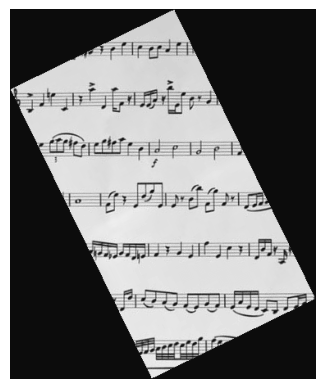

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

aligned_image = rotate(image, inclination)
plt.imshow(aligned_image, cmap = "gray")
plt.axis('off')

Rotating then the original image by the returned angle, we have an aligned result. The resultant image is in a slightly diferent gray scale (due to the black background added in the rotation method), but there were no worries in correcting the scale to the original once the objective was to study the rotation of the image and as the image was already aligned and completely understandable we choose to let it in this scale.

## The Hough Transform Method

### Ready to use Hough Transform

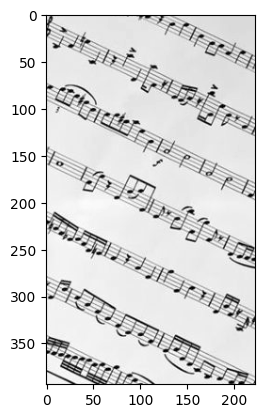

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("partitura.png", 0)

# Display the image
plt.imshow(image, cmap="gray")
plt.show()

This time we need to do the border detection of the image before anything. To do so, we are going to use the Canny algorithm for edge detection that do the high-pass filtering and the binarization simulteaneously, what will help us to execute the Hough Trasform.  

(-0.5, 222.5, 393.5, -0.5)

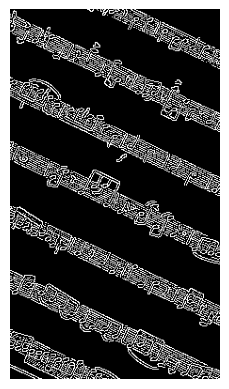

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("partitura.png", 0)

# Apply Canny edge detection
binary_image = cv2.Canny(image, 200, 200)

# Display the results
plt.imshow(binary_image, cmap="gray")
plt.axis('off')

Above we have the visualization of the post high-pass filtering using the ```cv2.Canny``` method. The ```binary_image``` now have only 0s and 255s values on it.



The ```hough_line``` function of the skimage lib used below, returns a tuple of three arrays. Each on of those represents usefull values to the interpretation of the Hough Transform.

*   **Theta array:** is the *theta* dimension of the Hough Space, each element corresponds to an angle, as standard the method takes 180 degree range from -90 to 89 degrees expressed in radians. Is important to notice that this defines the angle that the perpendicular distance of the potential line does with the x-axis.  
*   **D array:** corresponds to the *rho* dimension of the Hough Space, each element represents an integer perpendicular distance to the origin of the space. Notice that the integer scale can be altered to increase the precision of the method.
*   **H array:** represents an (D,theta) sized matrix that combines each possible value of D and theta to assign votes for each combination. Higher vote values in the H array represent a higher likelihood of the potential line represented by the combination (D,theta) be a real line in the image.



In [ ]:
from skimage.transform import hough_line
import math

# Apply the Hough transform
h, theta, d = hough_line(binary_image)
print("D dimensions: {} | D range: {} to {}\nTheta dimensions: {} | Theta range: {} to {}\nH dimensions: {}".format(d.shape,d[0],d[906],theta.shape,math.degrees(theta[0]),int(math.degrees(theta[179])),h.shape))


D dimensions: (907,) | D range: -453.0 to 453.0
Theta dimensions: (180,) | Theta range: -90.0 to 89
H dimensions: (907, 180)


Understanding the return of the ```hough_line``` method we can use that to quickly find the probably inclination angle of the image. The code snippet below takes the max value of votes in the returned *h matrix*, finds its column (that represent the angle of the probable line), looks for the matching index in the *theta matrix*, converts from radians to degrees and prints it on the screen.

In [ ]:
import numpy as np
import math

distances, angles = h.shape
max_val_column = np.argmax(h) % angles
likely_angle = math.degrees(theta[max_val_column])
print(likely_angle)

-64.0


Notice that this angle represents (by the definition set above) the inclination of the perpendicular distance (perpendicular line) to the x-axis and the negative signal represents a counter-clockwise rotation in the defined axis. In other words, undo this rotation by using the ```rotate``` method with the degree argument -64  (rotating the image clockwise by definition of negative degrees in the method) would align the image vertically wich is not the desired result.

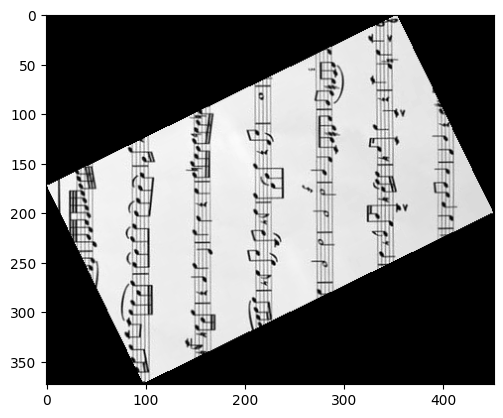

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

vertically_aligned_image = rotate(image, likely_angle)

plt.imshow(vertically_aligned_image, cmap = "gray")

Knowing that the result is the vertical align, to horizontally align the image we can just counter-clockwise rotate the vertically aligned image, this would give us the expected result as seen below.

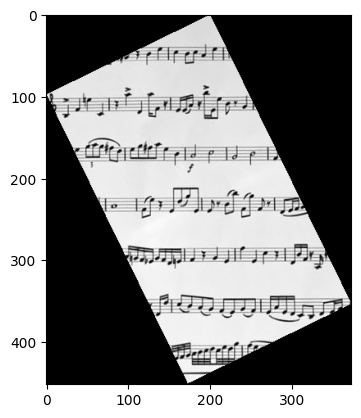

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

horizontally_aligned_image = rotate(vertically_aligned_image, 90)

plt.imshow(horizontally_aligned_image, cmap = "gray")

Another aproach would be taking the complementary angle to the probably angle found in the ```hough_line``` return analysis. This would give us the a 26 counter-clockwise (once it is related to the y-axis in this aproach) degree rotation that would return the same result.

### Manually implemented Hough Transform

Understanding the concepts behind the Hough Trasform and applying directly it's uses with the ready to use function, we can now implement the transform manually and understanding it's operation.

(-0.5, 661.5, 494.5, -0.5)

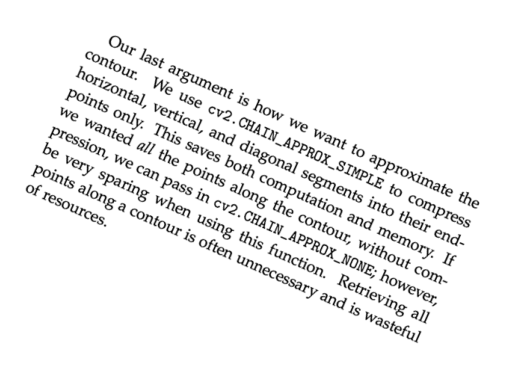

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("pos_24.png", 0)

# Display the image
plt.imshow(image, cmap="gray")
plt.axis("off")

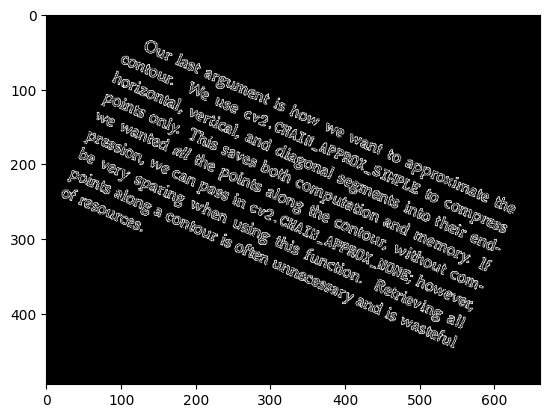

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Apply Canny edge detection
binary_image = cv2.Canny(image, 200, 200)

# Display the results
plt.imshow(binary_image, cmap="gray")
plt.show()

After loading the image and applying the Canny algorithm as done before, we can finally calculate the inclination angle using a manual implementation of the Hough transform. The functions defined below work together to transform the (x,y) coordinates of the image on the (ρ,θ) Hough space, using the formula ```xcos(θ) + ysin(θ) = ρ``` to iterate through every possible θ value, finding every possible combination (ρ,θ) generated by a pair (x,y) and accumulating the value on the respective cell of the *add_up matrix* that represents the *h matrix* on the last example.

In [ ]:
import math
import numpy as np
def accumulator_iteration(x,y,add_up):
  for i in range (0,180):
    rho = x*math.cos(math.radians(i)) + y*math.sin(math.radians(i))
    add_up[int(rho),i] += 1

def get_ht_inclination(image):
  m,n = image.shape
  add_up = np.zeros((int(math.sqrt((n**2)+(m**2))), 181))
  for i in range (1,m):
    for j in range (1,n):
        if (image[i,j] == 255):
          accumulator_iteration(i,j,add_up)
  print(n)
  return (np.argmax(add_up)%181)

likely_angle = get_ht_inclination(binary_image)
print("Probable angle: {}".format(likely_angle))

662
Probable angle: 156


The ```get_ht_inclination``` (where *ht* stands for Hough transform) returns the column of the max valued cell in the accumulator variable. In this case as our angle range is defined from 0 to 180 degrees, the return of the function represents the probable inclination degree based on the objective criterion as the voting over the angles of all Hough transform found lines.

(-0.5, 805.5, 720.5, -0.5)

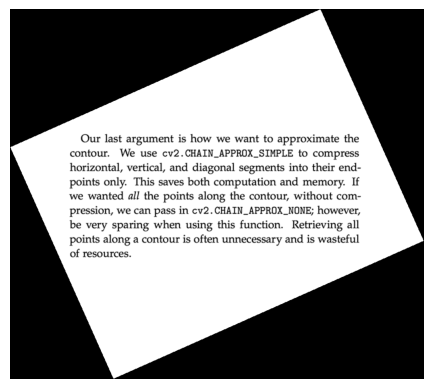

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

inclination_angle = 180 - likely_angle
horizontally_aligned_image = rotate(image, inclination_angle)

plt.imshow(horizontally_aligned_image, cmap = "gray")
plt.axis("off")